# Mobile language assistant with MobileVLM and OpenVINO
[MobileVLM](https://arxiv.org/abs/2312.16886) is a competent multimodal vision language model (MMVLM) targeted to run on mobile devices. It is an amalgamation of a myriad of architectural designs and techniques that are mobile-oriented, which comprises a set of language models at the scale of 1.4B and 2.7B parameters, trained from scratch, a multimodal vision model that is pre-trained in the CLIP fashion, cross-modality interaction via an efficient projector.

![](https://github.com/Meituan-AutoML/MobileVLM/raw/main/assets/mobilevlm_arch.png)

The MobileVLM architecture (right) utilizes [MobileLLaMA](https://huggingface.co/mtgv/MobileLLaMA-1.4B-Base) as its language model, intakes $\mathbf{X}_v$ and $\mathbf{X}_q$ which are image and language instructions as respective inputs and gives $\mathbf{Y}_a$ as the output language response. LDP refers to a lightweight downsample projector (left).

See more information on official [GitHub](https://github.com/Meituan-AutoML/MobileVLM) project page and [paper](https://arxiv.org/abs/2312.16886).
#### Table of contents:
- [Install requirements](#Install-requirements)
- [Clone MobileVLM repository](#Clone-MobileVLM-repository)
- [Import required packages](#Import-required-packages)
- [Load the model](#Load-the-model)
- [Convert model to OpenVINO Intermediate Representation (IR)](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR))
- [Inference](#Inference)
    - [Load OpenVINO model](#Load-OpenVINO-model)
    - [Prepare input data](#Prepare-input-data)
    - [Run generation process](#Run-generation-process)
- [Interactive inference](#Interactive-inference)


## Install requirements
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "torch>=2.0.1" "timm>=0.9.12" --extra-index-url "https://download.pytorch.org/whl/cpu"
%pip install -q "transformers>=4.33.1,<4.35.0" accelerate "sentencepiece>=0.1.99" "openvino>=2023.2.0" "nncf>=2.7.0" ipywidgets numpy gradio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Clone MobileVLM repository
[back to top ⬆️](#Table-of-contents:)

In [2]:
from pathlib import Path
import sys
MOBILEVLM_REPO_DIR = Path("./MobileVLM")
if not MOBILEVLM_REPO_DIR.exists():
    !git clone -q "https://github.com/Meituan-AutoML/MobileVLM.git"
sys.path.insert(0, str(MOBILEVLM_REPO_DIR))

## Import required packages
[back to top ⬆️](#Table-of-contents:)

In [3]:
import warnings
import itertools
import gc
from typing import Optional, List, Tuple

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import (
    disable_torch_init,
    process_images,
    tokenizer_image_token,
    KeywordsStoppingCriteria,
)
from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
import PIL
import torch
import transformers
import numpy as np
import gradio as gr
import openvino as ov
import nncf
import ipywidgets as widgets

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


In [4]:
MODELS_DIR = Path("./models")
MODEL_PATH = 'mtgv/MobileVLM-1.7B'

TEMPERATURE = 0.2
TOP_P = None
NUM_BEAMS = 1
MAX_NEW_TOKENS = 512

IMAGE_PATH = MOBILEVLM_REPO_DIR / "assets" / "samples" / "demo.jpg"
PROMPT_STR = "Who is the author of this book?\nAnswer the question using a single word or phrase."

## Load the model
[back to top ⬆️](#Table-of-contents:)

To load the model, we use pre-defined `load_pretrained_model` function in `mobilevlm` module. It returns the model itself, tokenizer, and image processor to convert images to appropriate tensors.

In [5]:
model_name = MODEL_PATH.split('/')[-1]
disable_torch_init()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tokenizer, model, image_processor, _ = load_pretrained_model(MODEL_PATH, device="cpu")
model = model.to(dtype=torch.float32)

## Convert model to OpenVINO Intermediate Representation (IR)
[back to top ⬆️](#Table-of-contents:)

In [6]:
def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2023.1/weight_compression.html).

Please select below whether you would like to run INT4 weight compression instead of INT8 weight compression.

In [7]:
compression_mode = widgets.Dropdown(
    options=['INT4', 'INT8'],
    value='INT4',
    description='Compression mode:',
    disabled=False,
)

compression_mode

Dropdown(description='Compression mode:', options=('INT4', 'INT8'), value='INT4')

In [8]:
stage1_xml_path = MODELS_DIR / f"stage1_{compression_mode.value}.xml"
stage2_xml_path = MODELS_DIR / f"stage2_{compression_mode.value}.xml"

In [9]:
if compression_mode.value == 'INT4':
    wc_parameters = dict(mode=nncf.CompressWeightsMode.INT4_ASYM, group_size=128, ratio=0.8)
else:
    wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

In [10]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None
    ):
        outputs = self.model.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds
        )
        hidden_states = outputs[0]
        logits = self.model.lm_head(hidden_states)

        return (logits,) + outputs[1:]

In [11]:
def set_input_names(model, past_key_values):
    input_names = [
        "input_ids",
        "attention_mask",
        *itertools.chain.from_iterable(
            [f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"]
            for idx, _ in enumerate(past_key_values)
        ),
    ]
    assert len(input_names) == len(model.inputs)
    for _input, input_name in zip(model.inputs, input_names):
        _input.get_tensor().set_names({input_name})

In [12]:
def set_output_names(model, past_key_values):
    output_names = [
        "logits",
        *itertools.chain.from_iterable(
            [f"present.{idx}.key", f"present.{idx}.value"]
            for idx, _ in enumerate(past_key_values)
        ),
    ]
    assert len(output_names) == len(model.outputs)
    for out, out_name in zip(ov_model.outputs, output_names):
        out.get_tensor().set_names({out_name})

In [13]:
example_input = {
    "inputs_embeds": torch.zeros((1, 205, 2048)),
    "attention_mask": torch.ones((1, 205), dtype=torch.long),
}

wrapped = ModelWrapper(model)
past_key_values = wrapped(**example_input)[1]

if not stage1_xml_path.exists():
    ov_model = ov.convert_model(wrapped, example_input=example_input)
    set_output_names(ov_model, past_key_values)
    ov_model = nncf.compress_weights(ov_model, **wc_parameters)
    ov.save_model(ov_model, stage1_xml_path)
    cleanup_torchscript_cache()
    del ov_model
    gc.collect()

In [14]:
example_input = {
    "input_ids": torch.ones((1, 1), dtype=torch.long),
    "past_key_values": past_key_values,
    "attention_mask": torch.ones((1, past_key_values[-1][-1].shape[-2] + 1), dtype=torch.long),
}

if not stage2_xml_path.exists():
    ov_model = ov.convert_model(
        wrapped,
        example_input=example_input,
    )
    set_input_names(ov_model, past_key_values)
    set_output_names(ov_model, past_key_values)
    ov_model = nncf.compress_weights(ov_model, **wc_parameters)
    ov.save_model(ov_model, stage2_xml_path)
    cleanup_torchscript_cache()
    del ov_model
    gc.collect()

In [15]:
prepare_inputs_labels_for_multimodal = model.prepare_inputs_labels_for_multimodal
prepare_inputs_for_generation = model.prepare_inputs_for_generation
config = model.config
config.save_pretrained(MODELS_DIR)

In [16]:
del wrapped
del model
gc.collect();

## Inference
[back to top ⬆️](#Table-of-contents:)

`OVMobileLlamaForCausalLM` class provides ease-to-use interface for using model in generation scenario. It is based on `transformers.generation.GenerationMixin` that gives us opportunity to reuse all reach capabilities for generation implemented in HuggingFace Transformers library. More details about this interface can be found in [HuggingFace documentation](https://huggingface.co/docs/transformers/main_classes/text_generation).

In [17]:
class OVMobileLlamaForCausalLM(transformers.GenerationMixin):
    def __init__(self, stage1_path, stage2_path, device):
        self.stage1 = core.compile_model(stage1_path, device)
        self.stage2 = core.read_model(stage2_path)

        self.generation_config = transformers.GenerationConfig.from_model_config(config)
        self.config = transformers.AutoConfig.from_pretrained(MODELS_DIR)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.prepare_inputs_for_generation = prepare_inputs_for_generation
        self.num_pkv = 2
        self.input_names = {key.get_any_name(): idx for idx, key in enumerate(self.stage2.inputs)}
        self.output_names = {key.get_any_name(): idx for idx, key in enumerate(self.stage2.outputs)}
        self.key_value_input_names = [key for key in self.input_names if "key_values" in key]
        self.key_value_output_names = [key for key in self.output_names if "present" in key]
        stage2 = core.compile_model(self.stage2, device)
        self.request = stage2.create_infer_request()

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> transformers.modeling_outputs.CausalLMOutputWithPast:
        return self.forward(input_ids, images, attention_mask, prefix_mask, past_key_values)

    def forward(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> transformers.modeling_outputs.CausalLMOutputWithPast:
        """General inference method"""
        inputs = {}
        if past_key_values is not None:
            # Flatten the past_key_values
            attention_mask = torch.ones(
                (input_ids.shape[0], past_key_values[-1][-1].shape[-2] + 1),
                dtype=input_ids.dtype,
            )
            past_key_values = tuple(
                past_key_value
                for pkv_per_layer in past_key_values
                for past_key_value in pkv_per_layer
            )
            # Add the past_key_values to the decoder inputs
            inputs = dict(zip(self.key_value_input_names, past_key_values))

        else:
            return self.forward_with_image(input_ids, images, attention_mask)
        inputs["input_ids"] = np.array(input_ids)

        if "attention_mask" in self.input_names:
            inputs["attention_mask"] = np.array(attention_mask)

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor("logits").data)

        # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
        past_key_values = tuple(
            self.request.get_tensor(key).data for key in self.key_value_output_names
        )
        # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)

        past_key_values = tuple(
            past_key_values[i : i + self.num_pkv]
            for i in range(0, len(past_key_values), self.num_pkv)
        )

        return transformers.modeling_outputs.CausalLMOutputWithPast(
            logits=logits, past_key_values=past_key_values
        )

    def forward_with_image(self, input_ids, images, attention_mask):
        """First step inference method, that resolves multimodal data"""
        _, attention_mask, _, input_embed, _ = prepare_inputs_labels_for_multimodal(
            input_ids, attention_mask, images=images, past_key_values=None, labels=None
        )
        outs = self.stage1({"inputs_embeds": input_embed, "attention_mask": attention_mask})
        logits = outs[0]
        pkv = list(outs.values())[1:]
        pkv = tuple(pkv[i : i + self.num_pkv] for i in range(0, len(pkv), self.num_pkv))
        return transformers.modeling_outputs.CausalLMOutputWithPast(
            logits=torch.from_numpy(logits), past_key_values=pkv
        )

Now, when we have model and defined generation pipeline, we can run model inference.

Select device from dropdown list for running inference using OpenVINO.

In [18]:
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Load OpenVINO model
[back to top ⬆️](#Table-of-contents:)

In [19]:
ov_model = OVMobileLlamaForCausalLM(stage1_xml_path, stage2_xml_path, device.value)

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

In [20]:
images = [PIL.Image.open(IMAGE_PATH).convert("RGB")]
images_tensor = process_images(
    images, image_processor, transformers.AutoConfig.from_pretrained(MODELS_DIR)
)

In [21]:
conv = conv_templates["v1"].copy()
conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + PROMPT_STR)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
input_ids = tokenizer_image_token(
    prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
).unsqueeze(0)
stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

Who is the author of this book?
Answer the question using a single word or phrase.


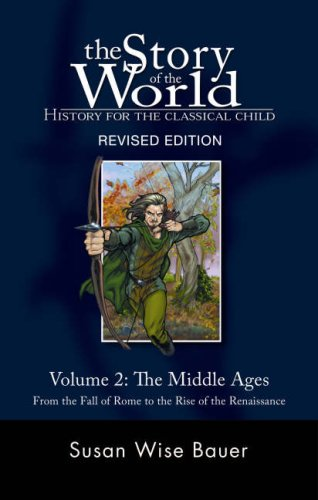

In [21]:
print(PROMPT_STR)
images[0]

### Run generation process
[back to top ⬆️](#Table-of-contents:)

In [22]:
output_ids = ov_model.generate(
    input_ids,
    images=images_tensor,
    do_sample=True if TEMPERATURE > 0 else False,
    temperature=TEMPERATURE,
    top_p=TOP_P,
    num_beams=NUM_BEAMS,
    max_new_tokens=MAX_NEW_TOKENS,
    use_cache=True,
    stopping_criteria=[stopping_criteria],
)
input_token_len = input_ids.shape[1]
n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
if n_diff_input_output > 0:
    print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")
outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[: -len(stop_str)]
print(f"🚀 {model_name} with OpenVINO: {outputs.strip()}\n")

🚀 MobileVLM-1.7B with OpenVINO: Susan Wise Bauer



## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [ ]:
def generate(img, prompt):
    images_tensor = process_images(
        [img], image_processor, transformers.AutoConfig.from_pretrained(MODELS_DIR)
    )
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv = conv_templates["v1"].copy()
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    input_ids = tokenizer_image_token(
        prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
    ).unsqueeze(0)
    stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

    output_ids = ov_model.generate(
        input_ids,
        images=images_tensor,
        do_sample=True if TEMPERATURE > 0 else False,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        num_beams=NUM_BEAMS,
        max_new_tokens=MAX_NEW_TOKENS,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )
    input_token_len = input_ids.shape[1]
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]

    return outputs.strip()


demo = gr.Interface(
    generate,
    [gr.Image(label="Image", type="pil"), gr.Textbox(label="Prompt")],
    gr.Textbox(),
    examples=[
        [
            str(IMAGE_PATH),
            PROMPT_STR,
        ]
    ],
    allow_flagging="never"
)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/